In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import datetime
import numpy as np
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline

In [2]:
bitcoin_market_info = pd.read_csv('../data/GBPJPY_day_short.csv')
#Date,Volumeの削除
bitcoin_market_info = bitcoin_market_info.drop(["day", "time", "volume"],
                                               axis=1)
datasize = bitcoin_market_info.shape[0]


In [3]:
bitcoin_market_info.head()

,close,open,high,low
0,137.282,139.407,139.461,137.282
1,135.903,137.205,137.319,132.484
2,138.063,135.894,138.297,135.803
3,138.879,138.032,138.928,137.611
4,138.215,138.880,139.437,137.972


In [4]:
#データの前処理
##欠損データの処理
bitcoin_market_info = bitcoin_market_info.replace(
    "-", np.nan).fillna(method="ffill")
bitcoin_market_info.index = range(datasize)


cols = bitcoin_market_info.columns

diff_list = []
for col in cols:
    diff_data = bitcoin_market_info.loc[:, col].pct_change()[1:]
    diff_data.index = range(datasize - 1)
    series = pd.Series(data=diff_data, dtype='float')
    diff_list.append(series)

df = pd.concat(diff_list, axis=1)

In [5]:
#時間方向を横軸に組み込んだDataFrameの作成
dataframe_list = [df]
wide = 3
keys = ["{}".format(i) for i in range(wide)]
for i in range(wide):
    data_kari = dataframe_list[i].drop(i)
    data_kari.index = range(datasize - (i + 2))
    dataframe_list.append(data_kari)
concat_df = pd.concat(dataframe_list, axis=1, keys=keys).dropna()
y = concat_df

In [6]:
#学習用データの作成
f = lambda x: 2 if x > 0.01 else 0 if x < -0.01 else 1
y = concat_df.iloc[:, 1].map(f).values.astype(np.int64)[:y.shape[0] - 1]
X = preprocessing.scale(concat_df).astype(np.float64)[1:, 1]

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=0)


def kentei(predict_y, test_y):
    count = 0
    for i in range(len(predict_y)):
        if predict_y[i] == 2 and test_y[i] == 0:
            count += 1
    return count / predict_y.tolist().count(2)


C_list = [10**i for i in range(-5, 7)]

In [7]:
# １D配列から２D配列へ変換
train_X=train_X.reshape(-1,1)
test_X=test_X.reshape(-1,1)

In [8]:
# グラフ描画用の空リストを用意
train_accuracy = []
test_accuracy = []

for C in tqdm(C_list):
    model = SVC(C=C)
    model.fit(train_X, train_y)
    train_accuracy.append(model.score(train_X, train_y))
    test_accuracy.append(model.score(test_X, test_y))

predict_y = model.predict(test_X)

100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


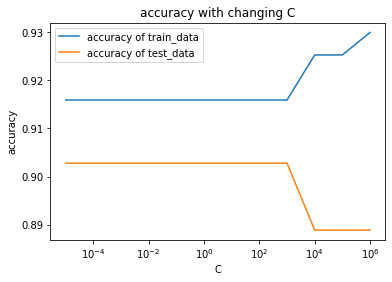

In [9]:
# グラフの準備
plt.semilogx(C_list, train_accuracy, label="accuracy of train_data")
plt.semilogx(C_list, test_accuracy, label="accuracy of test_data")
plt.title("accuracy with changing C")
plt.xlabel("C")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [11]:
print("Average score is {}".format(np.mean(test_accuracy)))
print("Max score is {}".format(np.max(test_accuracy)))

print("投資失敗率:{}".format(kentei(predict_y, test_y)))


Average score is 0.8993055555555557
Max score is 0.9027777777777778
投資失敗率:0.0
